In [77]:
from siftdetector import detect_keypoints
%matplotlib inline
from numpy_sift import SIFTDescriptor 
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/home/ubuntu/dev/opencv-3.1/build/lib')
import cv2
import time
import numpy as np
import cv2
from sklearn.cluster import KMeans
import os
from math import log
from tqdm import tqdm

# Introduction

In this tutorial, we will try to classify images using a bag-of-features approach. First, we will go through an example in a structured environment and try to classify images of racehorses and abbeys. Next, we will expand the problem to include classifying marine images. Namely we will try to classify images with seaweed-like objects in them. Through this tutorial, you will learn concepts such as detecting features, finding saliency of an image ... Lets begin!

## Part I.

In this pset folder, you will find two folders with images in them. In the folder abbey, there are 128x128 pictures of abbeys and in the folder racehorse, there are 128x128 pictures of racehorses. There are 18 pictures of racehorses and 21 pictures of abbeys. We will try to classify these images by constructing a feature vector for each of them. The first thing we need to do is find points of interest in these images. Here, we make the design choice to use the function goodFeaturesToTrack from OpenCV. This feature returns the most promient corners in the image. Run the code below to see it at work on a sample image. The points will be plotted in yellow.

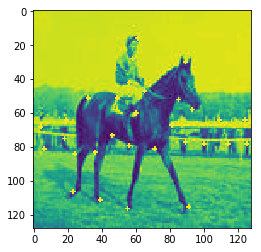

(<matplotlib.image.AxesImage at 0x1175f7190>, None)

In [13]:
display_img = cv2.imread('racehorse/00000002.jpg', 0)
display_corners = cv2.goodFeaturesToTrack(display_img,30,0.01,10)
display_corners = np.int0(display_corners)
for i in display_corners:
    x,y = i.ravel()
    cv2.circle(display_img,(x,y),1,255,-1)
plt.imshow(display_img),plt.show()

Now that we have our points of interest, or features, we need to extract the feature descriptors for each point. A popular method to do so is SIFT, and that is what we will be using here. SIFT operates on a portion or "patch" of the image, and returns a 128 length vector describing that patch.  In this example, we will be using a patch_size of 32. We will look at 31 features in each image, and get a 128 SIFT descriptor for each feature and concatenate them together to get one vector of length 3968 (31\*128) for each image. Then we will have a 36 x 3968 numpy array (because we have 36 pictures total, each with 3968 features) which we will then feed into a KMeans algorithm that will automatically cluster the pictures. We will then fit the original images to see how the KMeans algorithm clusters the pictures, and judge the accuracy of the classification method on how well it does.

In [61]:
def return_labels(directoryList, range_size, added_limit, count_limit, patch_size=32):
    SD = SIFTDescriptor(patchSize = patch_size)

    #creates initial vector of size 3968
    sift_pictures = np.asarray([[0 for _ in range(range_size)]])
    for directory in directoryList:
        #go through the directories with the relevant images
        for filename in os.listdir(directory):
            name = directory + '/' + filename
            if name[-3:] == 'png' or name[-3:] == 'jpg':
                image = cv2.imread(name)
                
                #transform it to black and white and get features
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                h, w = gray.shape
                corners = cv2.goodFeaturesToTrack(gray,count_limit,0.01,10)

                corners = np.int0(corners)
                image_sift_features = np.asarray([]) 
                count, actually_added = 0, 0
                
                #Here we want to get 31 images for our feature vector and then break out of the loop
                while actually_added < added_limit and count < count_limit:
                    corner = corners[count][0]
                    if patch_size/2 <= corner[1] <= h-patch_size/2 and patch_size/2 <= corner[0] <= w-patch_size/2:
                        patch = gray[corner[1]-patch_size/2:corner[1]+patch_size/2, corner[0]-patch_size/2:corner[0]+patch_size/2]
                        sift = SD.describe(patch)
                        image_sift_features = np.append(image_sift_features, sift)
                        actually_added += 1
                    count += 1

                sift_pictures = np.append(sift_pictures, [image_sift_features], axis=0)

    return sift_pictures[1:]


In [62]:
sift_pictures = return_labels(['abbey', 'racehorse'], 3968, 31, 100)
kmeans = KMeans(n_clusters=2, random_state=1).fit(sift_pictures)
test_pictures = return_labels(['test'], 3968, 31, 100)
print kmeans.predict(sift_pictures)
print kmeans.predict(test_pictures)


[1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]
[1 1 1 0 0 1]


In [ ]:
[1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]
[1 1 1 0 0 1]

The 0s and 1s correspond to which cluster KMeans is putting the images in. We can manually check that it is correctly or incorrectly classifying the images. It doesn't matter which cluster KMeans puts an image in, just that it is putting abbey images (the first 21 images) and racecar images (the next 15 images) in different clusters. As it turns out, we classified 30/36 of our original images correctly and 5/6 of our test images correctly, not bad!

## Part II.

OK, now lets turn to image classification in unstructured environments, marine images. We will try to classify pictures of seaweed from just regular pictures of sand. To get more of a feel for these kinds of images, feel free to look through the sand and seaweed image folders. First, lets go back to the object detection we first looked at and try to apply it to our new marine image.

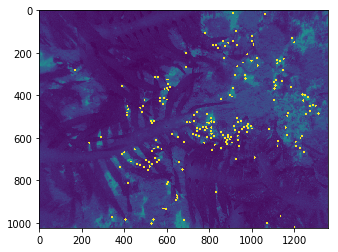

(<matplotlib.image.AxesImage at 0x118744350>, None)

In [54]:
display_img = cv2.imread('seaweed/PR_20081014_010133_346_LC16.png', 0)
display_corners = cv2.goodFeaturesToTrack(display_img,200,0.01,10)
display_corners = np.int0(display_corners)
for i in display_corners:
    x,y = i.ravel()
    cv2.circle(display_img,(x,y),5,255,-1)
plt.imshow(display_img),plt.show()

We notice that the corner detector has a harder time finding features in this situation because the image is cluttered with extra objects--the seaweed is not the focus of the image like the abbey or racehorses were. There are also fewer well-defined 'corners' in this image, further complicating the issue. We see these issues crop up if we try to run our algorithm from before on our new images. In this case there are 6 seaweed images and 5 sand images. 

In [59]:
naive_sift_pictures = return_labels(['seaweed', 'sand'], 38400, 300, 1000, 1000)
naive_kmeans = KMeans(n_clusters=2, random_state=1).fit(naive_sift_pictures)
print naive_kmeans.predict(naive_sift_pictures)

[1 1 1 1 1 0 1 1 1 1 1]


Ouch, it looks like everything is being classified to the same cluster. Now, we will attempt to fix this through two methods- one involving hue and the other entropy.

### Hue

To try and alleviate this issue, we will add extra features to our feature vector in addition to using the ones that SIFT gives us. One feature we will be using will be hue, which has been proven to be important for marine image classification from preliminary tests. For the hue value, we will convert the image into HSV space, then pull out the H values only. Then whenever we get a patch, we take the average value over all the hue values in that patch, and this becomes our extra features. We could just append this to our feature vector and have 129 features, but we want this new feature to be weighted more equally with the existing SIFT features, so we will add it 150 times to our feature vector, and the new total size of the vector will be 278.

In [74]:
def hue_features(directoryList, range_size, added_limit, count_limit, patch_size=32):

    SD = SIFTDescriptor(patchSize = patch_size)
    sift_pictures = np.asarray([[0 for _ in range(range_size)]])
    #go through the directories sand and seaweed
    for directory in ['sand', 'seaweed']:
        for filename in os.listdir(directory):
            name = directory + '/' + filename
            if name[-3:] == 'png' or name[-3:] == 'jpg':
                image = cv2.imread(name)
                #convert image into HSV space and get just the Hue in variable HR
                hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
                pixels = hsv.reshape((hsv.shape[0], hsv.shape[1], 3))
                H, S, V = pixels.T
                HR = H.T
                
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                #get corner features as before
                corners = cv2.goodFeaturesToTrack(gray, count_limit, 0.01,10)
                corners = np.int0(corners)

                image_sift_features = np.asarray([]) 
                count, actually_added = 0, 0

                while actually_added < added_limit and count < count_limit:
                    corner = corners[count][0]
                    if 16 <= corner[1] <= 1008 and 16 <= corner[0] <= 1344:
                        patch = gray[corner[1]-16:corner[1]+16, corner[0]-16:corner[0]+16]
                        #get the value of our new feature, the average hue value in the patch
                        color = np.average(HR[corner[1]-16:corner[1]+16, corner[0]-16:corner[0]+16])
                        sift = SD.describe(patch)
                        #append the new feature 150 time
                        sift = np.append(sift, [color for _ in range(150)])
                        image_sift_features = np.append(image_sift_features, sift)
                        actually_added += 1
                    count += 1

                sift_pictures = np.append(sift_pictures, [image_sift_features], axis=0)

    return sift_pictures[1:]
      

In [75]:
hue_sift_pictures = hue_features(['seaweed', 'sand'], 83400, 300, 1000)
hue_kmeans = KMeans(n_clusters=2, random_state=1).fit(hue_sift_pictures)
print hue_kmeans.predict(hue_sift_pictures)

[0 0 1 0 0 1 1 0 1 1 1]


This time our classification scheme did much better, making only two errors.

### Entropy

Another useful feature in unstructured environments is a saliency measure. This looks at the entropy in a certain part of the image. If this portion of the image has a high entropy, that means that there is a busy region with lots of different parts that is more useful to us. In contrast, if it is a low entropy region, this means that it is a uniform area, not of as much interest. The equations for calculating entropy are below and are used in the following code after the corner detection algorithm has returned regions of interest. We then want to look at these regions of interest, and find the highest entropy ones to use as our top features. 

The entropy function is typically defined as

$$E(\Delta I)=H=-\sum_{i=1}^{n}p(x_{i})\log p(x_{i})$$

For the gray scale image we define the probability $p(x)$ as follows,

$$p(x_{i})={h(x_{i\over N})={1\over N}\sum_{j=1}^{N}\delta(x_{i}-x_{j})}$$

where $\delta$ is the discrete Dirac delta function:
$$\delta(x)=\cases{1, x=0\cr 0, x\neq 0 } $$

So finally the entropy of a patch with $N_p$ pixels will be:
$$H_{g}=-{1\over N_{p}}\sum_{j=1}^{N_{p}}\log p_{g}(x_{j}) $$
It is important to note that we are calculating the log probability, $p_{g}$ using all the pixels in the image, but the outermost sum is just over the pixels in the patch.


NOTE:  The following code will take several minutes to run! This is expected.

In [105]:
#This funtion is calcuating the entropy using the equations above and returns the 'value' highest corner points
def get_max(corners, h, w, patch_size, gray, value=10):
    entropy_points = {}
    for corner in corners:
        x, y = corner[0]
        entropy = 0
        if (patch_size/2) <= y <= h-(patch_size/2) and (patch_size/2) <= x <= w-(patch_size/2):
            for row in range(x-4, x+4):
                for col in range(y-4, y+4):
                    #this line is counting up all the locations where the pixels are the same
                    entropy += len(np.where(gray==gray[col][row])[0])
            entropy_points[(x,y)] = -log(float(entropy)/(h*w))/64
    return sorted(entropy_points.items(), key=lambda x: entropy_points[x[0]], reverse=True)[:value]


def entropy_features(directoryList, range_size, count_limit, patch_size=64):
    SD = SIFTDescriptor(patchSize = patch_size)
    sift_pictures = np.asarray([[0 for _ in range(range_size)]])
    count = 1
    for directory in ['sand', 'seaweed']:
        for filename in os.listdir(directory):
            name = directory + '/' + filename
            if name[-3:] == 'png' or name[-3:] == 'jpg':
                print str(count) + "/11 finished"
                image = cv2.imread(name, 0)
                h,w = image.shape
                corners = cv2.goodFeaturesToTrack(image,count_limit,0.01,10)
                image_sift_features = np.asarray([]) 
                corners = np.int0(corners)
                highest_entropy = get_max(corners, h, w, patch_size, image)
                for point in highest_entropy:
                    point = point[0]
                    patch = image[point[1]-32:point[1]+32, point[0]-32:point[0]+32]
                    sift = SD.describe(patch)
                    image_sift_features = np.append(image_sift_features, sift)
                sift_pictures = np.append(sift_pictures, [image_sift_features], axis=0)
                
                count += 1
    
    return sift_pictures[1:]


In [106]:
entropy_sift_pictures = entropy_features(['seaweed', 'sand'], 1280, 100)
entropy_kmeans = KMeans(n_clusters=2, random_state=1).fit(entropy_sift_pictures)
print entropy_kmeans.predict(entropy_sift_pictures)

1/11 finished
2/11 finished
3/11 finished
4/11 finished
5/11 finished
6/11 finished
7/11 finished
8/11 finished
9/11 finished
10/11 finished
11/11 finished
[0 0 0 0 0 0 0 0 1 0 0]


Although the entropy code did not have as much impact on the accuracy as the hue did, saliency is an important concept to understand when talking about image classification in unstructured environments!